# Calculating Claim Statistics for a Subset of Patents using the Google Patents Public Datasets on BigQuery.

-----------------

Copyright 2017 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0
     
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


## Overview

Imagine you're analyzing a subset of patents and want to do some text analysis of the first independent claim. To do this, you'd need to be able to join your list of patent publication numbers with a dataset containing the patent text. Additionally, you'd need a method to extract the first claim from the rest of the claims. This notebook is a demonstration of one method to perform this analysis using python, BigQuery, and Google's [new public dataset on patents](https://cloud.google.com/bigquery/public-data/google-patents). 

What follows is a walkthrough of how to extract the first claim from a set of US Patent publications and run a few summary statistics against the first claim. The set of patents we analyze in this notebook is a random sample of 20,000 patents filed between 1995 and present in the G06F Cooperative Patent Classification (CPC) code, however this analysis could be repeated for any arbitrary list of patents of interest. 

The steps we'll use to get there are:
1. Create a new BigQuery "dataset" where we can store our results. For anyone new to bigquery, check out [the quickstart guide](https://cloud.google.com/bigquery/quickstart-web-ui).
2. Upload a list of patent publications we wish to analyze.
3. Join this list with Google's public patent data.
4. Extract the first claim using regular expressions and BigQuery User Defined Functions.
5. Calculate summary statistics about the first claims and plot results over time.


## Pre-requisites
- A google cloud account with access to BigQuery. If you don't have an account yet, [this page](https://cloud.google.com/free/) will guide you through the process to get started with an account and access the free tier of services.
- Basic knowledge of how to run a query using the BigQuery web UI. If you're new to this, check out [this page](https://cloud.google.com/bigquery/public-data/) for a quick intro.
- Basic knowledge of [pandas dataframes](https://pandas.pydata.org/pandas-docs/stable/10min.html) and python programming.
- A few python packages (pandas, seaborn, matplotlib and google-api-python-client.

In [0]:
from __future__ import print_function
from google.cloud import bigquery
import pandas as pd
import matplotlib.pylab as plt
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
import uuid
import time
# Variables to be used throughout the notebook, replace with your project
# and desired dataset name.
PROJECT_ID = 'my_project_name'
DEST_DATASET = 'claims_analysis'

# Create a python client we can use for executing table creation queries
client = bigquery.Client(project=PROJECT_ID)
# Create an HTTP client for additional functionality.
credentials = GoogleCredentials.get_application_default()
http_client = discovery.build('bigquery', 'v2', credentials=credentials)

In [0]:
%matplotlib inline

## 1. Create a new BigQuery Dataset

During this analysis, we're going to be leveraging BigQuery to do most of the computation and we'll store our results in tables in BigQuery. To organize this, we'll need a new dataset to work with. We'll use the API to create a new dataset. For more on working with the BigQuery python client library, see [this page](https://cloud.google.com/bigquery/docs/reference/libraries#client-libraries-install-python).

In [0]:
dataset_ref = client.dataset(DEST_DATASET)
dataset = bigquery.Dataset(dataset_ref)
client.create_dataset(dataset)
print('Dataset {} created.'.format(dataset.dataset_id))

## 2. Upload a list of Publication Numbers for analysis

 In this hypothetical example, we are planning to inspect the first claims from a set of patents. To do this, we need to get our list of publication numbers into BigQuery. Since this is just an example, we're going to use a random sample of 20k G06F patents we have saved to a CSV file and added to this repo, but this could be any set of patents you're interested in. We'll leverage [pandas "to_gbq" method]("https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_gbq.html") to simplify this. (Note, you could also do this from the [web UI or API.]("https://cloud.google.com/bigquery/loading-data") )


The steps we need to complete are:

1. Load a csv containing publication numbers.
2. Store these records in a new table in our BigQuery dataset. 

In [0]:
# Load a list of patents from disk
df = pd.read_csv('./data/20k_G_and_H_publication_numbers.csv')
df.head(5)

,publication_number
0,US-2004088502-A1
1,US-2008085107-A1
2,US-2002021306-A1
3,US-9104683-B2
4,US-2002097416-A1


In [0]:
# Upload these to our dataset on BigQuery.
pubs_table = 'claim_text_publications'
full_table_path = '{}.{}'.format(DEST_DATASET, pubs_table)
df.to_gbq(destination_table=full_table_path,
          project_id=PROJECT_ID,
          if_exists='replace')




Streaming Insert is 50.0% Complete
Streaming Insert is 100.0% Complete




## 3. Join our uploaded list of publications with the patents-public-data on BigQuery to get the text of the claims, priority year, and classification code at the 4 digit level. 

In the next section, we'll begin using the public patent data which is available on Big Query. Among numerous other fields, this table includes the text of the patent claims, the CPC code, and priority date of the patent claims. Because BigQuery doesn't have a "create table as" syntax, we've created a function to handle constuction of a call to the BigQuery python API. This is simply a helper function, which takes a query and produces a table. This can also easily by done [using the web UI](https://cloud.google.com/bigquery/docs/tables).

The steps to be completed are:

1. Write a query which produces a 4 column table: publication number, priority year, CPC code (split at 4 digits), and the full text of the claims. 
2. Run this query, and write the results to a table in our project/dataset.

In [0]:
def create_table_as(query_string, dest_table, project_id=PROJECT_ID, dest_dataset=DEST_DATASET,
                    http_client=http_client, overwrite=True, use_legacy_sql=False):
  """Simulates a 'create table as' statement in BigQuery.

  Args:
    query_string: A string query that produces rows of data.
    dest_table: string table name to use for storing results.
    project_id: string project id to use for running query and storing results.
    dest_dataset: String name of dataset to use for storing results.
    http_client: An http client for use in inserting the BigQuery Job.
    overwrite: Should new data be appended to existing data or overwritten?
    use_legacy_sql: Defaults to standard_sql, but option to use legacy.

  Raises:
    Exception: If the BigQuery job finshes with an error, a general Exception is raised
    with the error message from BigQuery included.
  """
  write_disposition = 'WRITE_TRUNCATE'
  if not overwrite:
    write_disposition = 'WRITE_APPEND'
  config = {
      'kind': 'bigquery#job',
      'projectId': str(uuid.uuid4()),
      'configuration': {
          'query': {
              'query': query_string,
              'destinationTable': {
                  'projectId': project_id,
                  'datasetId': dest_dataset,
                  'tableId': dest_table
              },
              'createDisposition': 'CREATE_IF_NEEDED',
              'writeDisposition': write_disposition,
              'useLegacySql': use_legacy_sql
          }
      }
  }
  done = False
  request = http_client.jobs().insert(
      projectId=project_id, body=config).execute()
  job_id = request['jobReference']['jobId']
  while not done:
    jobs = http_client.jobs().list(projectId=project_id).execute()
    matches = [j for j in jobs['jobs'] if j['jobReference']['jobId'] == job_id]
    if matches[0]['state'] == 'DONE':
      if matches[0].get('errorResult'):
        raise Exception(
            'Create table failed: {}'.format(matches[0]['errorResult']))
      done = True
    print('Job still running...')
    time.sleep(5)

  print('Created table {}.'.format(dest_table))

In [0]:
query = """
#standardSQL

WITH P AS (
  SELECT 
  DISTINCT publication_number, 
  substr(cpc.code, 1,4) cpc4,
  floor(priority_date / 10000) priority_yr
  FROM `patents-public-data.patents.publications`,
  unnest(cpc) as cpc
  WHERE substr(cpc.code, 1,4) = 'G06F'
  AND floor(priority_date / 10000) >= 1995
  AND country_code = 'US'
)

SELECT 
P.publication_number,
P.priority_yr,
P.cpc4,
claims.text
FROM `patents-public-data.patents.publications` as pubs,
UNNEST(claims_localized) as claims
JOIN P 
  ON P.publication_number = pubs.publication_number
JOIN `{}.{}.{}` my_pubs
  ON pubs.publication_number = my_pubs.publication_number
WHERE claims.language = 'en'
""".format(PROJECT_ID, DEST_DATASET, pubs_table)
create_table_as(query, '20k_G06F_pubs_after_1994')

Job still running...
Job still running...
Job still running...
Job still running...
Job still running...
Created table 20k_G06F_pubs_after_1994.


### Lets inspect the contents of this new table we've created

We've now written these results to a table, lets take a look at the output. First, we'll pull down a random sample of 500 rows using a BigQuery trick for selecting a random sample (see below). We'll get the data with a handy pandas function, ["read_gbq"](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_gbq.html). Once we get the data in memory, let's look at the distribution of priority years and inspect a few example claims. 


- To get a random sample of roughly n_rows, we can simply include a statement in our where clause that looks like:

   ```
   where rand() < n_rows / total_rows_in_table```

- Since we have about 20k rows and we want a sample of about 500, this becomes:
  ```
  where rand() < 500 / 20000```

In [0]:
query = """
SELECT *
FROM `{}.{}.20k_G06F_pubs_after_1994`
WHERE RAND() < 500/20000 
""".format(PROJECT_ID, DEST_DATASET)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

In [0]:
# Quick visualization of the first 5 rows
df.head()

,publication_number,priority_yr,cpc4,text
0,US-5867718-A,1995.0,G06F,We claim: \n \n 1. A method of pow...
1,US-6006313-A,1995.0,G06F,What is claimed is: \n \n 1. An el...
2,US-5774588-A,1995.0,G06F,What is claimed is: \n \n 1. A met...
3,US-5678063-A,1995.0,G06F,What is claimed is: \n \n 1. An in...
4,US-5758179-A,1995.0,G06F,I claim: \n \n 1. A match bus oper...


In [0]:
# Do we have a mix of data from 1995-present?
df.priority_yr.value_counts().sort_index()

1995.0    19
1996.0    23
1997.0    24
1998.0    26
1999.0    17
2000.0    43
2001.0    50
2002.0    62
2003.0    73
2012.0    73
2013.0    45
2014.0    21
2015.0     6
Name: priority_yr, dtype: int64

In [0]:
# What do the claims look like?
for claim in df.sample(2).text:
  print('-----' * 5, '\n\nEXAMPLE CLAIM: \n\n', claim[:3000])

------------------------- 

EXAMPLE CLAIM: 

 What is claimed is:  
       
         1 . A method for implementing a distributed file system on a storage area network, comprising: 
 accepting a request at a client to access a file;    performing a lookup in a local cache to determine what physical disk blocks are associated with the request; and    if the lookup cannot be satisfied in the local cache, 
 forwarding the request from the client to a server,  
 receiving a block map for the file from the server, wherein the block map includes location information specifying physical blocks corresponding to the file, and  
 using information from the block map to access the file on the storage device directly without going through the server.  
   
     
         
         2 . The method of  claim 1 , wherein the block map includes only a portion of the location information for the file.  
     
         
         3 . The method of  claim 2 , wherein if the request to access the file is a r

## Extract the First Claims Using A UDF in Big Query

Since we have the full claim above, we need a way to parse out just the first claim. BigQuery has [User Defined Functions (UDF's)](https://cloud.google.com/bigquery/docs/reference/standard-sql/user-defined-functions) which let the user pass columns through some arbitrary function. In our case, we need some logic to parse the claims and split after the first claim has ended. In most cases we can simply split on the text "1." but there are also cases where the text is not so cleanly formatted. The UDF below shows and example of using javascript regular expressions to parse the first claim.

The basic logic is to work down the following options, returning the first positive match:

1. Try to split on '2.' or '2 .'.
2. Find the first mention of 'claim 1' and split there.
3. Handle canceled claims by finding the word canceled and determining which claim was the first non-canceled claim.
4. Look for a sentence beginning with "The" - split and return the first half.
5. Finally, just return the first 2000 characters. 

In [0]:
# The JS script to run against the text of our claims.
js = r"""

// Regex to find a period followed by any number of spaces and '2.' or '2 .'
var pattern = new RegExp(/[.][\\s]+[2][\\s]*[.]/, 'g');
if (pattern.test(text)) {
  return text.split(pattern)[0];
}

// If none of the above worked, try to find a reference to claim 1.
if (text.indexOf('claim 1 ') > -1) {
  return text.split('claim 1 ')[0];
}

// Look for claim cancelations and return first non-canceled claim
text = text.replace(/canceled/i, 'canceled')
text = text.replace(/cancelled/i, 'canceled')
if (text.indexOf('(canceled)') > -1) {
	text = text.split('(canceled)')
	canceled = text[0];
	not_canceled = text[1];
	// Determine first non-cancelled claim
	if (canceled.indexOf('-') > -1 ) {
		next_claim = parseInt(canceled.split('-')[1]) + 1
	}
	else {
		next_claim = 2;
	}
	// Split on next_claim + 1
	return not_canceled.split(next_claim + 1)[0].trim();
}


// If none of the above worked, try to find a sentence starting with 'The'
// This should only happen after claim 1 has been defined.
if (text.indexOf(' The ') > -1) {
  return text.split(' The ')[0];
}

// if none of the above worked return the first 2000 characters. 
return text.slice(0,2000);
"""

In [0]:
# Insert the JS code above into this string, and pass it to Big Query
query = r'''
#standardSQL
CREATE TEMPORARY FUNCTION get_first_claim(text STRING)
RETURNS STRING
LANGUAGE js AS """
{}
"""; 

 
SELECT 
pubs.*, 
get_first_claim(text) first_claim
FROM `{}.{}.20k_G06F_pubs_after_1994` pubs
'''.format(js, PROJECT_ID, DEST_DATASET)
CLAIM_TEXT_TABLE = '20k_G06F_pubs_after_1994_split_first_claim'
create_table_as(query, CLAIM_TEXT_TABLE)

Job still running...
Job still running...
Job still running...
Job still running...
Created table 20k_G06F_pubs_after_1994_split_first_claim.


In [0]:
query = """
SELECT * FROM `{}.{}.{}` WHERE RAND() < 500/20000 
""".format(PROJECT_ID, DEST_DATASET, CLAIM_TEXT_TABLE)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

## Let's See how that UDF Performed

One way to test the UDF would be to run a query in bigquery against an example we can test. For example:

```SELECT get_first_claim("1. test claim 1 2. test claim 2");```

We can also run this claim against real data and pull down a sample, which is shown below. We've now created a new table which has both the full claims text as well as our extracted first claim. Lets compare a few to see how well it worked.

In [0]:
for idx, row in df.sample(2).iterrows():
  print('------' * 10, '\nORIGINAL CLAIM TEXT:\n', '------' * 10)
  print(row.text[:2000], '\n')
  print('------' * 10, '\nRESULT AFTER PARSING WITH UDF:\n', '------' * 10)
  print(row.first_claim, '...\n\n')

------------------------------------------------------------ 
ORIGINAL CLAIM TEXT:
 ------------------------------------------------------------
1 . A visual display system for a vehicle, comprising: 
 at least one sensor operable to capture images representing scenery outside the vehicle;    a protective housing enclosing the at least one sensor, wherein the protective housing further comprises a transparent aperture through which the at least one sensor captures images;    a cleaning mechanism operable to remove obstructions from the transparent aperture; and    an operator display through which images representing scenery outside the vehicle are displayed.    
   
       
       2 . The visual display system of  claim 1 , wherein the at least one sensor further comprises a camera.  
   
       
       3 . The visual display system of  claim 1 , wherein the transparent aperture further comprises a rotating transparent conical surface, wherein an outer surface of the transparent conic

# Lastly, lets use BigQuery to calculate some statistics about the first claim.

From the start, the goal here was to compute some summary statistics about claims for a specific set of patents. Namely, we're interested to see if the number of elements, character counts, or word counts have varied over time. 

-----------------

## Average Word Count by Year

In [0]:
# Average Word Count by Year:
query = r"""
#standardSQL
with words as (
  SELECT 
  publication_number,
  priority_yr,
  SPLIT(REGEXP_REPLACE(first_claim, r'\s{2,}', ''), ' ') word
  FROM `%s.%s.%s`
)

SELECT 
  priority_yr, 
  avg(num_words) avg_word_cnt
FROM (
  SELECT
  publication_number,
  priority_yr,
  count(*) as num_words
  from words, unnest(word)
  group by 1,2
)
GROUP BY 1
ORDER BY 1
""" %(PROJECT_ID, DEST_DATASET, CLAIM_TEXT_TABLE)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

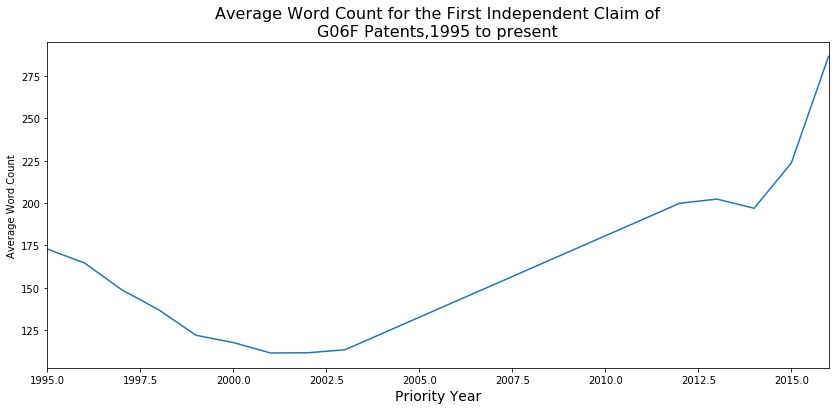

In [0]:
plt.figure(figsize=(14, 6))
plt.plot(df.priority_yr, df.avg_word_cnt)
plt.xlabel('Priority Year', fontsize=14)
plt.xlim(1995, 2016)
plt.ylabel('Average Word Count')
plt.title('Average Word Count for the First Independent Claim of\nG06F Patents,'
          '1995 to present', fontsize=16)
plt.show()

## Average Number of Elements by Year

In [0]:
query = """
#standardSQL
with elements as (
  SELECT 
  publication_number,
  priority_yr,
  SPLIT(first_claim, ';') element
  FROM `%s.%s.%s`
)

SELECT 
  priority_yr, 
  avg(num_elements) avg_element_cnt
FROM (
  SELECT
  publication_number,
  priority_yr,
  count(*) as num_elements
  from elements, unnest(element)
  group by 1,2
)
GROUP BY 1
ORDER BY 1
""" %(PROJECT_ID, DEST_DATASET, CLAIM_TEXT_TABLE)
df = pd.read_gbq(query, project_id=PROJECT_ID, dialect='standard')

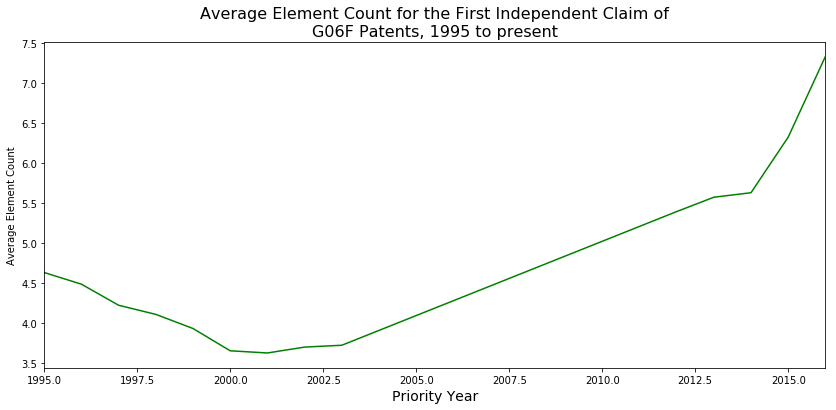

In [0]:
plt.figure(figsize=(14, 6))
plt.plot(df.priority_yr, df.avg_element_cnt, color='g')
plt.xlabel('Priority Year', fontsize=14)
plt.xlim(1995, 2016)
plt.ylabel('Average Element Count')
plt.title('Average Element Count for the First Independent Claim of\n'
          'G06F Patents, 1995 to present', fontsize=16)
plt.show()